In [112]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import scipy.signal
from datetime import datetime as dt
import cmocean
import datetime
from matplotlib.dates import DateFormatter
import glob
# import math
# from astropy.convolution import convolve
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.dates as mdates
#from scipy.optimize import curve_fit
import pandas as pd
import csv
myFmt = mdates.DateFormatter('%m-%d')

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [409]:
def calc_k_approx(T, rho_vals=np.linspace(50,1000,96)):

    """ calculate k values based on eq5 from calonne 2019
        T is in Kelvin """

    import numpy as np

    # rhos = []
    # ks = []

    # constants for calculation
    a = 0.02 # m3/kg
    k_ref_i = 2.107 # W/m/K
    k_ref_a = 0.024 # W/m/K

    # # just use simple values for now, will want them to be functions of T later
    # # current values for T=-3C
    k_i = 9.828*np.exp(-5.7*10.**(-3)*T)
    k_a = 0.023 # get the rest of the linear approx of T?

    # for rho in rho_vals:

    theta = 1./(1.+np.exp(-2.*a*(rho_vals-450.)))
    k_ref_firn = 2.107 + 0.003618*(rho_vals-917.)
    k_ref_snow = 0.024 - (1.23*10**(-4))*rho_vals + (2.5*10**(-6))*(rho_vals**2)

    ks = (1. - theta)*(k_i*k_a/(k_ref_i*k_ref_a))*k_ref_snow \
        + theta*(k_i/k_ref_i)*k_ref_firn

        # ## 2022-11-28 make high density levels have k look like sea ice,
        # ## i.e. take into account brine based on Pringle 2007 w/ 5 ppt
        # if rho>450.:
        #     phi = 1./(1.+np.exp(-2.*a*(rho-800.)))
        #     x_f = (1. - theta)*(k_i*k_a/(k_ref_i*k_ref_a))*k_ref_snow \
        #             + theta*(k_i/k_ref_i)*k_ref_firn*(1.-phi) \
        #             + phi*calc_k_ice(rho, T-273., S=5.)
        # else:
        #     x_f = (1. - theta)*(k_i*k_a/(k_ref_i*k_ref_a))*k_ref_snow \
        #         + theta*(k_i/k_ref_i)*k_ref_firn


        # # print(x_f)
        # ks.append(np.float32(x_f))#[0])
        # rhos.append(np.float32(rho))

    return ks

## Loading data

In [271]:
## SIMBA surface from SIMBA_surface_detection_v2_split_vertical.ipynb
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')

simba_sfc_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_in = df['max_index'].values

In [272]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
## new adjusted temps (no smoothing)
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc'
simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data = {}
varnames = ['temperature','initial_height','time']
fdic = load_netcdf(simba_filepath+simba_fname, varnames)

fstart_time = dt.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')

fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

for var in ['temperature','dates','initial_height']:
    season_data[var] = fdic[var]

In [273]:
## interpolate simba_sfc to have same timesteps as rest of simba data
sfc_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_sfc_dates])
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in season_data['dates']])

f_sfc = interpolate.interp1d(sfc_seconds, simba_sfc_in, fill_value=-999, bounds_error=False)
simba_sfc = f_sfc(simba_seconds)
simba_sfc = np.ma.masked_equal(simba_sfc, -999)

In [274]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')

# asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/full_period/'
# asfs_lev2_files = glob.glob(asfs_filepath+'sleighsfsseb.sleighsfs.level2.0.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','snow_gpr_dist','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = dt.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )


with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp'] = np.ma.MaskedArray(**npz)

## use corrected LW fluxes
df = pd.read_csv('Raven_2024_corrected_LW_fluxes.csv')
lw_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['Dates'].values])

for var_in, var_out in zip(['corrected LWU [W m-2]', 'corrected LWD [W m-2]'],['up_long_hemisp_corr','down_long_hemisp_corr']):
    pd_var = np.array(df[var_in].values)
    pd_var[np.where(pd_var=='--')] = '-999'
    asfs_data_lev2[var_out] = np.ma.masked_equal(pd_var.astype(np.float64), -999)
    
# asfs_data_lev2['up_long_hemisp_corr'] = df['corrected LWU [W m-2]'].values
# asfs_data_lev2['down_long_hemisp_corr'] = np.array(df['corrected LWD [W m-2]'].values)


asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['net_long_hemisp'] = asfs_data_lev2['down_long_hemisp_corr'] - asfs_data_lev2['up_long_hemisp_corr']
asfs_data_lev2['net_rad_hemisp'] = asfs_data_lev2['net_long_hemisp'] + asfs_data_lev2['net_short_hemisp']

asfs_data_lev2['uncorr_net_long_hemisp'] = asfs_data_lev2['down_long_hemisp'] - asfs_data_lev2['up_long_hemisp']


/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

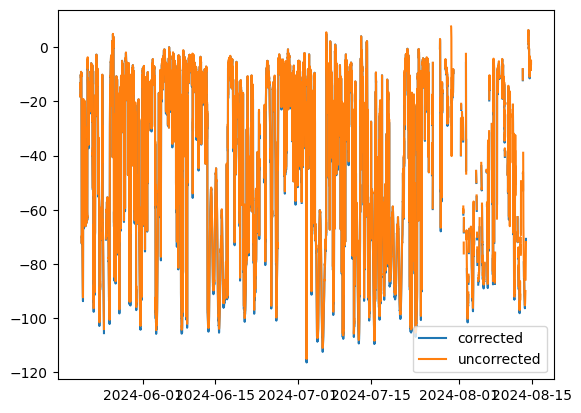

In [316]:
plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['net_long_hemisp'], label='corrected')

plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['uncorr_net_long_hemisp'], label='uncorrected')
plt.legend(loc='best')
plt.show()

In [276]:
df = pd.read_csv('/psd3data/arctic/sledd/Melt_Index_despiked_GPR_Raven2024.csv')

gpr_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['date'].values])       
gpr_melt = df['Melt_Index_Normal'].values


In [277]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
# fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data_solar = {}
if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data_solar['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature' and fn=='firnprofile_maxheight_solar-correction_created_20250417.nc':
        season_data_solar['temperature'] = fdic['temp']
    else:
        season_data_solar[var] = fdic[var]

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    season_data_solar['height'] = season_data_solar['initial_height'][::-1]
    season_data_solar['temperature'] = season_data_solar['temperature'][:,::-1]
else:
    season_data_solar['height'] = season_data_solar['initial_height']

## Starting analysis: accumulation of atmospheric fluxes

In [226]:
sleigh_dates = asfs_data_lev2['dates']
sleigh_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in sleigh_dates])

In [227]:
season_idx = np.where(sleigh_dates<dt(2024,7,24))

In [378]:
cumul_atm_flxs = {}

for flx in ['net_short_hemisp', 'net_long_hemisp', 'net_rad_hemisp']:
    flx_data = np.ma.masked_invalid(asfs_data_lev2[flx].copy())
    cumul_atm_flxs[flx] = flx_data.cumsum()*10.*60. # convert from Watts to Joules

net_short_hemisp 272.53491833515466
net_long_hemisp -227.32280380789462
net_rad_hemisp 40.517642175660754


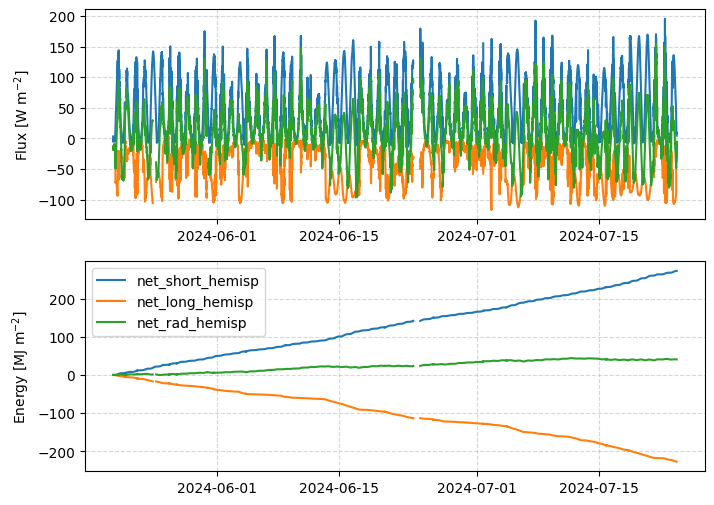

In [381]:
fig, axs = plt.subplots(2, figsize=(8,6))

for flx in ['net_short_hemisp', 'net_long_hemisp', 'net_rad_hemisp']:
    axs[0].plot(sleigh_dates[season_idx], asfs_data_lev2[flx][season_idx], label=flx)
    axs[1].plot(sleigh_dates[season_idx], cumul_atm_flxs[flx][season_idx]/10.**6, label=flx)
    print(flx, cumul_atm_flxs[flx][season_idx][-1]/10.**6)
    
axs[0].grid(alpha=.5, ls='--')
axs[1].grid(alpha=.5, ls='--')
axs[0].set_ylabel('Flux [W m$^{-2}$]')
axs[1].set_ylabel('Energy [MJ m$^{-2}$]')
axs[1].legend(loc='best')
plt.show()

In [454]:
swt_lo = np.exp(-10.*.3)*asfs_data_lev2['net_short_hemisp'][season_idx]
swt_mid = np.exp(-15.*.3)*asfs_data_lev2['net_short_hemisp'][season_idx]
swt_hi = np.exp(-20.*.3)*asfs_data_lev2['net_short_hemisp'][season_idx]
swt_accum = np.ma.masked_less(swt_mid,0).cumsum()*10.*60./10**6

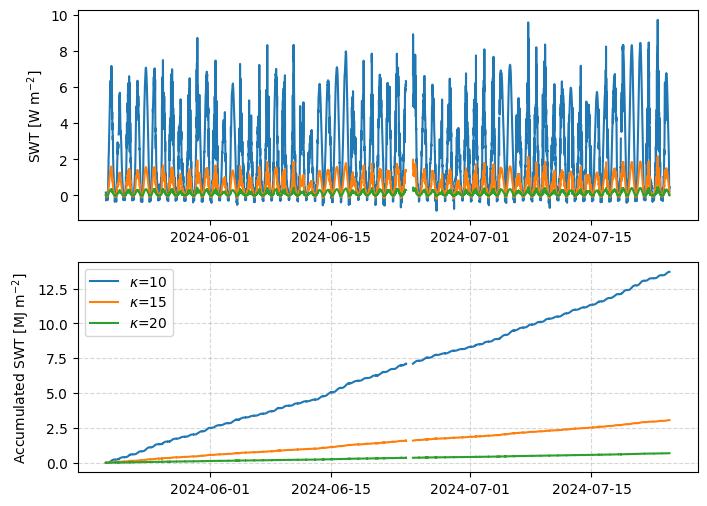

In [443]:
fig, axs = plt.subplots(2, figsize=(8,6))

for swt, k in zip([swt_lo, swt_mid, swt_hi],[10,15,20]):
    # OK to mask values less than 0? I don't tihnk it makes physical sense that there would be any SWT up...
    swt_a = np.ma.masked_less(swt,0).cumsum()*10.*60./10**6
    axs[0].plot(sleigh_dates[season_idx], swt, label='$\kappa$='+str(k))
    axs[1].plot(sleigh_dates[season_idx], swt_a, label='$\kappa$='+str(k))

for ax in axs.ravel():
    plt.grid(alpha=.5, ls='--')
axs[1].legend(loc='best')
axs[0].set_ylabel('SWT [W m$^{-2}$]')
axs[1].set_ylabel('Accumulated SWT [MJ m$^{-2}$]')
plt.show()

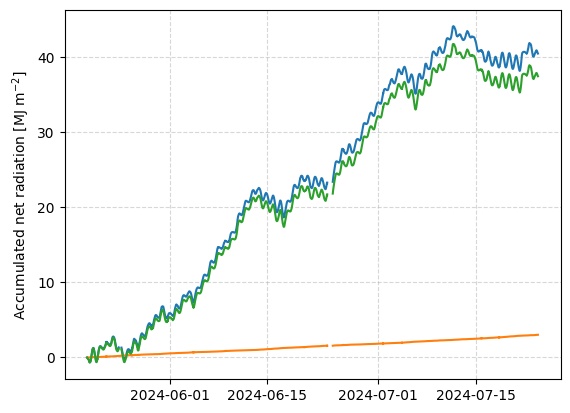

In [387]:
plt.plot(sleigh_dates[season_idx], cumul_atm_flxs['net_rad_hemisp'][season_idx]/10.**6)
plt.plot(sleigh_dates[season_idx], swt_accum, label='SWT')

plt.plot(sleigh_dates[season_idx], cumul_atm_flxs['net_rad_hemisp'][season_idx]/10.**6-swt_accum)

plt.grid(alpha=.5, ls='--')

plt.ylabel('Accumulated net radiation [MJ m$^{-2}$]')
plt.show()

## Continuing analysis: subsurface energy accumulation

Need to adjust temperatures to be relative to surface for getting upper Xcm

In [288]:
simba_depths = season_data_solar['height']
simba_temps = season_data_solar['temperature']
simba_dates = season_data_solar['dates']
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_dates])

In [289]:
print(simba_temps.shape, simba_dates.shape, simba_seconds.shape)

(6527, 160) (6527,) (6527,)


In [290]:
sfc_idx = np.where( (season_data['dates']>=season_data_solar['dates'][0])&(season_data['dates']<=season_data_solar['dates'][-1]) )
# sfc_idx = np.where( (simba_sfc_dates>=season_data_solar['dates'][0])&(simba_sfc_dates<=season_data_solar['dates'][-1]) )



In [291]:
depths_rel_to_sfc = np.repeat(season_data_solar['height'].copy()[np.newaxis,:], season_data_solar['temperature'].shape[0], axis=0)

sfc_2d = np.ma.repeat(simba_sfc[sfc_idx[0],np.newaxis], season_data_solar['temperature'].shape[1], axis=1)
depths_rel_to_sfc = depths_rel_to_sfc-sfc_2d

In [292]:
print(simba_seconds.shape, season_data_solar['temperature'].shape, depths_rel_to_sfc.shape)

(6527,) (6527, 160) (6527, 160)


In [293]:
temporary_temp = np.ma.masked_where(depths_rel_to_sfc>0, season_data_solar['temperature'])# temporary temperature

temps_rel_to_sfc = []

m = 100 # size of 

for i in range(temporary_temp.shape[0]):
    temp_i = temporary_temp[i,:-1]
    sub_t = temp_i[~temp_i.mask]

    sub_t_filled = np.ma.concatenate( (sub_t, np.full(int(m-sub_t.count()), -999 )) )
    temps_rel_to_sfc.append(sub_t_filled)
    
temps_rel_to_sfc = np.ma.masked_equal(temps_rel_to_sfc, -999)

In [294]:
sub_depths = np.arange(0,temps_rel_to_sfc.shape[1])
sub_depths *= -2

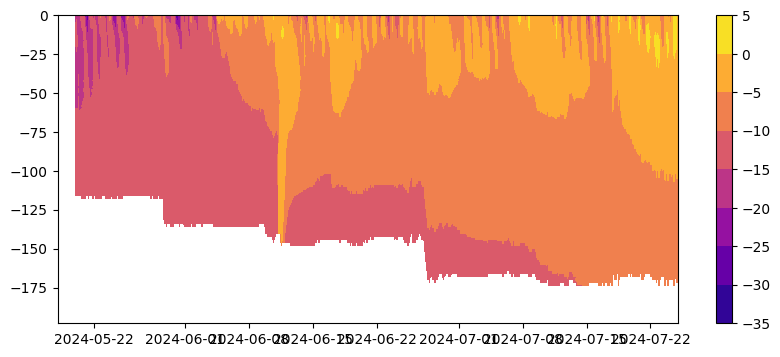

In [295]:
fig, axs = plt.subplots(1, figsize=(10,4))

cb = plt.contourf(simba_dates, sub_depths, np.swapaxes(temps_rel_to_sfc,0,1), cmap='plasma')
# plt.plot(simba_dates, simba_sfc-6.,  c='k')
plt.colorbar(cb)

# plt.xlim(dt(2024,6,8),dt(2024,6,15))
plt.show()

In [296]:
temps_rel_to_sfc = np.ma.masked_invalid(temps_rel_to_sfc)

temp_counts = temps_rel_to_sfc.count(axis=0)

## std dev w/ depth
temp_std_profile = temps_rel_to_sfc.std(axis=0)

l = temps_rel_to_sfc.count(axis=0)[0]
temp_std_full = np.ma.masked_where(temp_counts<l, temp_std_profile)


## correlations to surface/skin temperature w/ depth
temp_corrs = np.ma.corrcoef(temps_rel_to_sfc[:,0], temps_rel_to_sfc[:,1:].T)[0][1:]
# temp_corrs_skin = np.ma.corrcoef(skinT_sfc_timesteps, temps_rel_to_sfc[:,:].T)[0][1:]

# warming relative to surface - also test warming at each level?
dT_dt_rel_to_sfc = temps_rel_to_sfc[1:,:] - temps_rel_to_sfc[:-1,:]
dT_dt_rel_to_sfc = dT_dt_rel_to_sfc.sum(axis=0)

In [473]:
dT_dz = np.gradient(simba_temps, 0.02, axis=1)

In [474]:
temporary_grad = np.ma.masked_where(depths_rel_to_sfc>0, dT_dz)# temporary temperature

dT_dz_rel_to_sfc = []

m = 100 # size of 

for i in range(temporary_grad.shape[0]):
    temp_i = temporary_grad[i,:-1]
    sub_t = temp_i[~temp_i.mask]

    sub_t_filled = np.ma.concatenate( (sub_t, np.full(int(m-sub_t.count()), -999 )) )
    dT_dz_rel_to_sfc.append(sub_t_filled)
    
dT_dz_rel_to_sfc = np.ma.masked_equal(dT_dz_rel_to_sfc, -999)

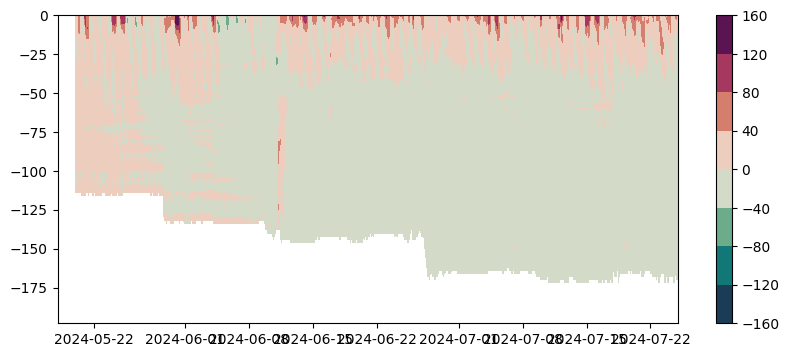

In [475]:
fig, axs = plt.subplots(1, figsize=(10,4))

cb = plt.contourf(season_data_solar['dates'], sub_depths, np.swapaxes(dT_dz_rel_to_sfc,0,1), cmap=cmocean.cm.curl)
# plt.plot(simba_dates, simba_sfc-6.,  c='k')
plt.colorbar(cb)

# plt.xlim(dt(2024,6,8),dt(2024,6,15))
plt.show()

Cold content

In [476]:
d_layer = 30

In [477]:
# rho_s = 300. # kg m-3
c_i = 2.1*10**-3 # MJ kg-1 C-1
# d_s = .2 # m
d = 0.02 # m
T_m = 0. # C

# rough estimates from snow pits at install and demob; maximum range
# uncertainty across instruments/sites greater than uncerainty between 20 and 30cm
# density in kg/m3
if d_layer==20:
    rho_lo = np.linspace(238, 229, temps_rel_to_sfc.shape[0])
    rho_hi = np.linspace(328, 379, temps_rel_to_sfc.shape[0])
elif d_layer==30:
    rho_lo = np.linspace(242, 226, temps_rel_to_sfc.shape[0])
    rho_hi = np.linspace(325, 387, temps_rel_to_sfc.shape[0])

# cold content units: MJ m−2
# Eq 2 in https://doi.org/10.5194/tc-12-1595-2018
cold_content_lo = c_i*rho_lo*d*temps_rel_to_sfc[:,np.where(sub_depths>=-d_layer)[0]].sum(axis=1)
cold_content_hi = c_i*rho_hi*d*temps_rel_to_sfc[:,np.where(sub_depths>=-d_layer)[0]].sum(axis=1)

cc_avg_lo = c_i*rho_lo*0.2*temps_rel_to_sfc[:,np.where(sub_depths>=-d_layer)[0]].mean(axis=1)
cc_avg_hi = c_i*rho_hi*0.2*temps_rel_to_sfc[:,np.where(sub_depths>=-d_layer)[0]].mean(axis=1)

Storage

In [478]:
avg_temps = np.ma.copy(temps_rel_to_sfc)[:,np.where(sub_depths>=-d_layer)[0]].mean(axis=1)

In [479]:
avg_temp_diff = avg_temps[2:] - avg_temps[:-2]
# time_diff = 2.*(simba_seconds[sfc_idx[0]][2:] - simba_seconds[sfc_idx[0]][:-2])
time_diff = 2.*(simba_seconds[2:] - simba_seconds[:-2])

print(avg_temp_diff.shape, time_diff.shape, rho_lo.shape)

# 10^6 to convert from MJ to J - from c_i used in cold content that's in MJ
storage_avg_lo = 10.**6*c_i*rho_lo[1:-1]*(d_layer/100.)*avg_temp_diff/time_diff
storage_avg_hi = 10.**6*c_i*rho_hi[1:-1]*(d_layer/100.)*avg_temp_diff/time_diff

(6525,) (6525,) (6527,)


In [480]:
storage_avg_lo_cum = storage_avg_lo.cumsum()
storage_avg_hi_cum = storage_avg_hi.cumsum()

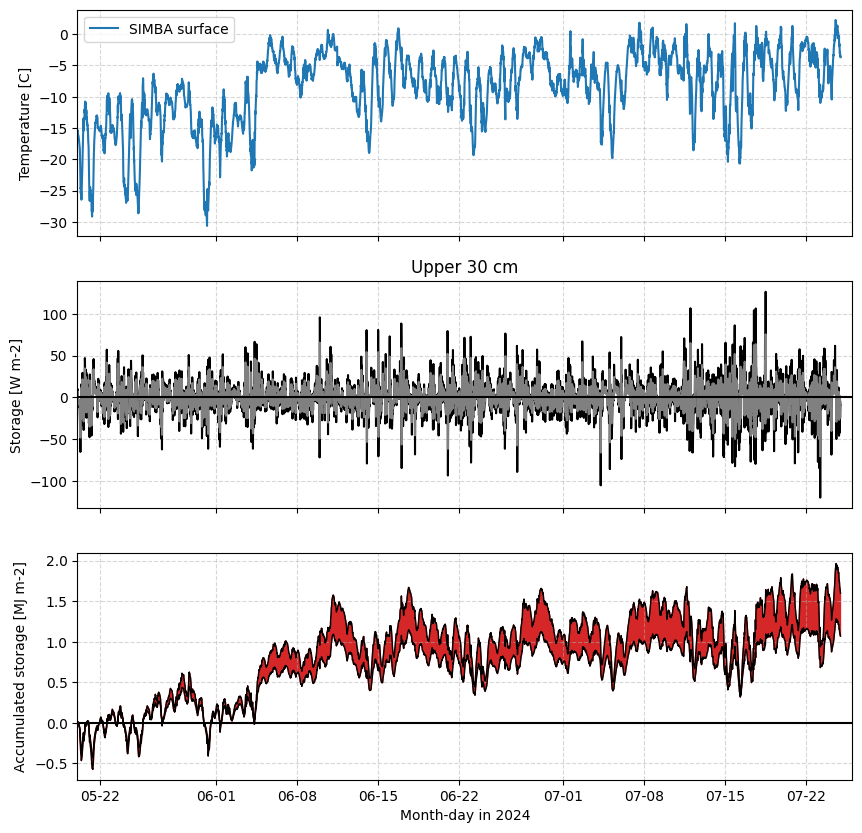

In [481]:
fig, axs = plt.subplots(3, figsize=(10,10), sharex=True)

# axs[0].plot(simba_dates, simba_skin-273.15, label='SLEIGH skin')
# plt.plot(simba_dates, np.ma.masked_less(simba_skin-273.15, -0.4), c='k')
# axs[0].plot(simba_dates, np.ma.masked_less(simba_skin-273.15, -0.32), c='r')

axs[0].plot(simba_dates, temps_rel_to_sfc[:,0], label='SIMBA surface')
axs[0].legend(loc='best')
axs[0].set_ylabel('Temperature [C]')

for ax in axs.ravel():
    ax.grid(ls='--', alpha=.5)


axs[1].fill_between(simba_dates[1:-1], storage_avg_lo, storage_avg_hi)
# plt.plot(simba_dates, cc_avg_lo,c='tab:red')
axs[1].plot(simba_dates[1:-1], storage_avg_hi, c='k')
axs[1].plot(simba_dates[1:-1], storage_avg_lo, c='gray')
axs[1].set_ylabel('Storage [W m-2]')
axs[1].axhline(y=0,c='k')

axs[2].fill_between(simba_dates[1:-1], storage_avg_lo_cum*15.*60./10**6, storage_avg_hi_cum*15.*60./10**6, color='tab:red')
axs[2].plot(simba_dates[1:-1], storage_avg_lo_cum*15.*60./10**6, c='k', lw=1)
axs[2].plot(simba_dates[1:-1], storage_avg_hi_cum*15.*60./10**6, c='k', lw=1)
axs[2].set_ylabel('Accumulated storage [MJ m-2]')
axs[2].axhline(y=0,c='k')

axs[2].xaxis.set_major_formatter(myFmt)
axs[2].set_xlabel('Month-day in 2024')
axs[1].set_title('Upper {:.0f} cm'.format(d_layer))
axs[2].set_xlim(dt(2024,5,20),dt(2024,7,26))
# add: skin temperature, net radiation (SEB), GPR melt probability, others...?
# plt.savefig('/home/asledd/ICECAPS/simba_solar_correction_figs/Raven_corrected-simba_20ks_0.5nir_-6sfc_cold-content_sum-t.png', dpi=250)

plt.show()

Need an estimate for conduction at bottom of 30cm. Should also average?

If conduction doesn't balance this, then I'm off by a factor of 10+ and need to go back through the calcuations

In [482]:
## make some fake data to see what order of magnitude is needed
fake_turb = np.full(storage_avg_hi.shape, 7.)
fake_turb_cum = fake_turb.cumsum()*15.*60./10**6

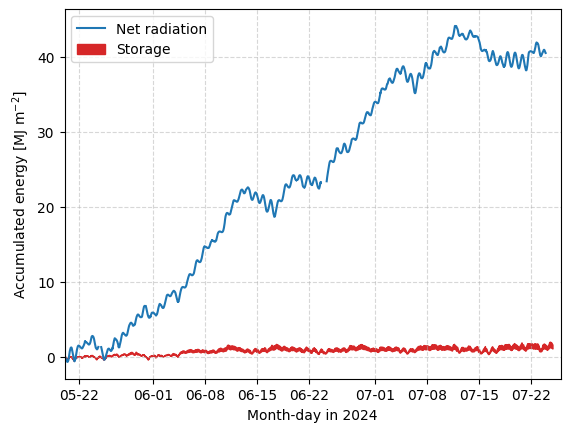

In [483]:
fig, ax = plt.subplots(1)

ax.plot(sleigh_dates[season_idx], cumul_atm_flxs['net_rad_hemisp'][season_idx]/10.**6, label='Net radiation')

ax.fill_between(simba_dates[1:-1], storage_avg_lo_cum*15.*60./10**6, storage_avg_hi_cum*15.*60./10**6, color='tab:red', label='Storage')
# ax.plot(simba_dates[1:-1], fake_turb_cum, label='turbulence=7')

ax.grid(alpha=.5, ls='--')
ax.legend(loc='best')
ax.set_ylabel('Accumulated energy [MJ m$^{-2}$]')

ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
# ax.set_title('Upper {:.0f} cm'.format(d_layer))
ax.set_xlim(dt(2024,5,20),dt(2024,7,26))
plt.show()

In [484]:
k_s = 0.7 ## just for now! should at least make some attempt to calculate it from density and get a range

In [485]:
## test impact of using a couple levels instead of one?

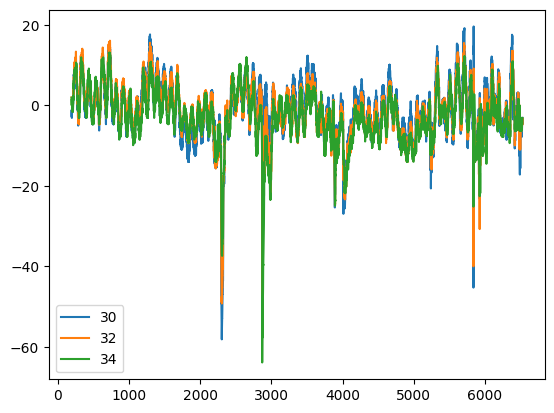

In [486]:
for d in range(d_layer, d_layer+5, 2):
    plt.plot(dT_dz_rel_to_sfc[:,np.where(sub_depths==-d)[0]], label=d)

plt.legend(loc='best')
plt.show()

In [487]:
## this is going ot be off? end of density is for demob, which was a month after end of continuous measurements
if d_layer==30:
    rho_lo_FC = np.linspace(315, 358, temps_rel_to_sfc.shape[0])
    rho_hi_FC = np.linspace(380, 399, temps_rel_to_sfc.shape[0])
    # rho_hi_FC = np.linspace(380, 450, temps_rel_to_sfc.shape[0])

else:
    print('GO GET DENSITY ESTIMATES!!!')

d_level_T = temps_rel_to_sfc[:,np.where(sub_depths==-d_layer)[0]]+273.15

ks_lo = calc_k_approx(np.squeeze(d_level_T), np.squeeze(rho_lo_FC))
ks_hi = calc_k_approx(np.squeeze(d_level_T), np.squeeze(rho_hi_FC))

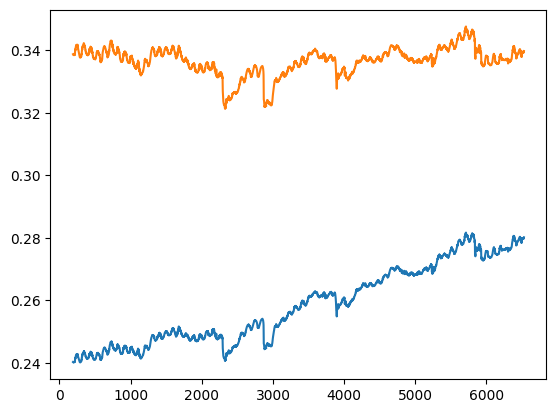

In [488]:
plt.plot(ks_lo)
plt.plot(ks_hi)

In [492]:
d_level_dTdz = np.squeeze(dT_dz_rel_to_sfc[:,np.where(sub_depths==-d_layer)[0]])

FC_d_level_lo = -ks_lo*d_level_dTdz#*100. # convert from cm to m -> now in np.gradient()
FC_d_level_hi = -ks_hi*d_level_dTdz#*100. # convert from cm to m -> now in np.gradient()

FC_lo_cum = FC_d_level_lo.cumsum()*15.*60./10.**6
FC_hi_cum = FC_d_level_hi.cumsum()*15.*60./10.**6

In [493]:
print(d_level_dTdz.shape, ks_lo.shape, FC_hi_cum.shape)

(6527,) (6527,) (6527,)


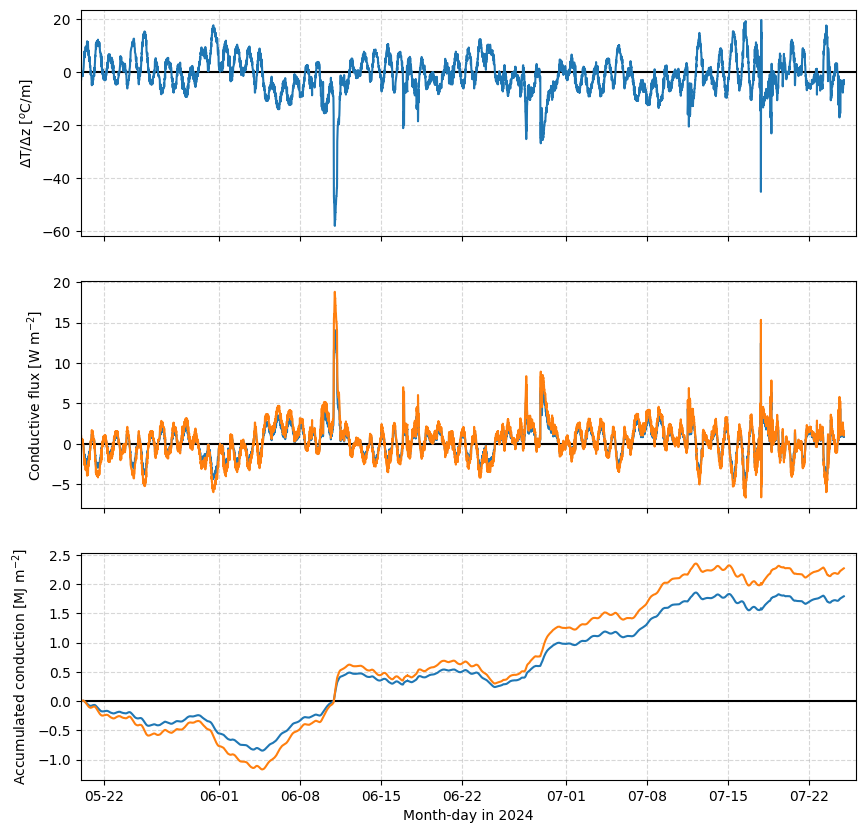

In [494]:
fig, axs = plt.subplots(3, figsize=(10,10), sharex=True)

ylabels = ['$\Delta$T/$\Delta$z [$^o$C/m]', 'Conductive flux [W m$^{-2}$]', 'Accumulated conduction [MJ m$^{-2}$]']
for i, dataset in enumerate([[d_level_dTdz], [FC_d_level_lo,FC_d_level_hi], [FC_lo_cum, FC_hi_cum]]):

    axs[i].axhline(y=0, c='k')
    for data in dataset:
        axs[i].plot(season_data_solar['dates'], data)
    axs[i].set_ylabel(ylabels[i])
    axs[i].grid(alpha=.5, ls='--')

        
axs[2].set_xlim(dt(2024,5,20),dt(2024,7,26))
    
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].set_xlabel('Month-day in 2024')
plt.show()


are calculations off? or just missing turbulence???

In [456]:
net_rad = np.ma.masked_invalid(asfs_data_lev2['net_rad_hemisp'])

f_var = interpolate.interp1d(sleigh_seconds[~net_rad.mask], net_rad[~net_rad.mask], 
                             fill_value=-999, bounds_error=False)

interp_net_rad = f_var(simba_seconds)
interped_net_rad = np.ma.masked_equal(interp_net_rad, -999)

In [467]:
f_var = interpolate.interp1d(sleigh_seconds[season_idx][~swt_accum.mask], swt_accum[~swt_accum.mask], 
                             fill_value=-999, bounds_error=False)

interp_swt_accum = f_var(simba_seconds)
interped_swt_accum = np.ma.masked_less(interp_swt_accum, -100)


f_var = interpolate.interp1d(sleigh_seconds[season_idx][~swt_mid.mask], swt_mid[~swt_mid.mask], 
                             fill_value=-999, bounds_error=False)

interped_swt_mid = f_var(simba_seconds)
interped_swt_mid = np.ma.masked_less(interped_swt_mid, -100)

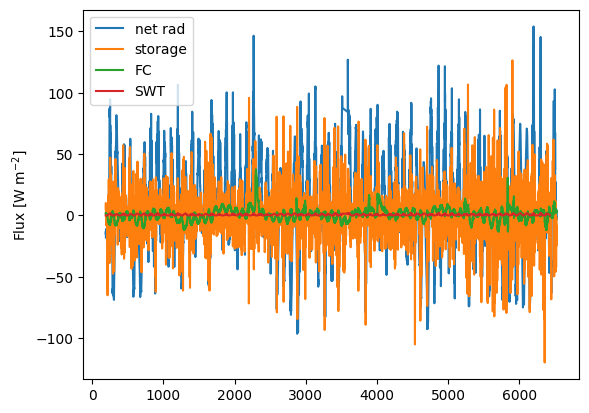

In [472]:
labels = ['net rad','storage','FC','SWT']
for i, var in enumerate([interped_net_rad[1:-1], storage_avg_hi, np.squeeze(FC_d_level_hi)[1:-1], interped_swt_mid[1:-1]]):
    plt.plot(var, label=labels[i])

plt.ylabel('Flux [W m$^{-2}$]')
plt.legend(loc='best')
plt.show()

(6527, 1) (6527,)


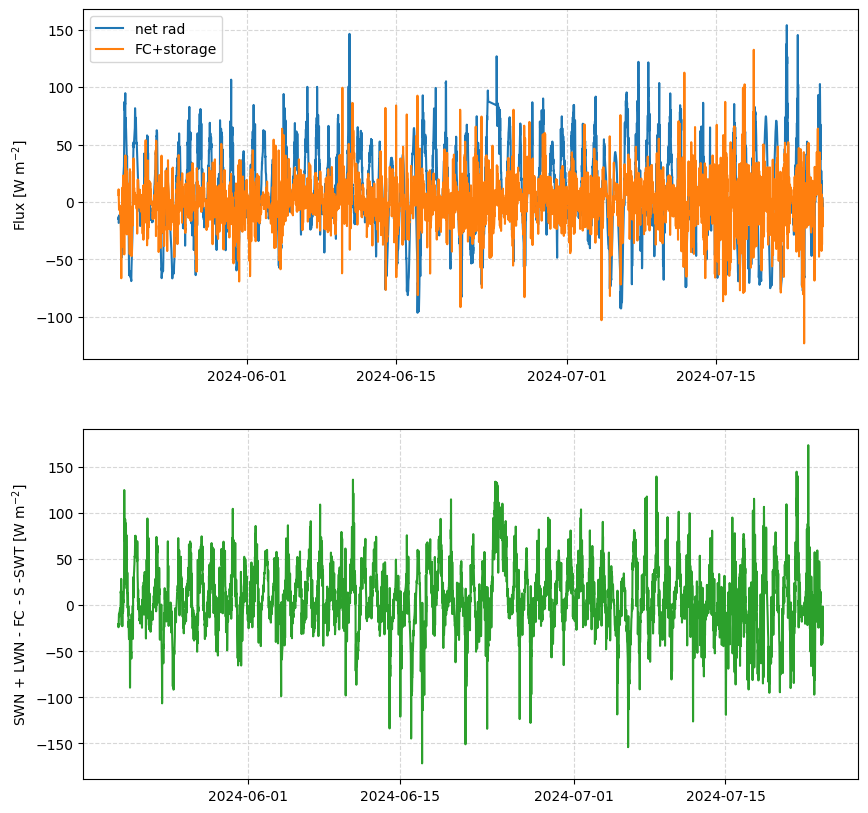

In [468]:
print(FC_d_level.shape, interped_net_rad.shape)

resid_no_turb = interped_net_rad[1:-1] - np.squeeze(FC_d_level_hi)[1:-1] - storage_avg_hi - interped_swt_mid[1:-1]

fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].plot(simba_dates, interped_net_rad, label='net rad')
axs[0].plot(simba_dates[1:-1], np.squeeze(FC_d_level_hi)[1:-1] + storage_avg_hi, label='FC+storage')
axs[0].legend(loc='best')

axs[1].plot(simba_dates[1:-1], resid_no_turb, c='tab:green')
axs[1].set_ylabel('SWN + LWN - FC - S -SWT [W m$^{-2}$]')
axs[0].set_ylabel('Flux [W m$^{-2}$]')

for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
plt.show()

In [365]:
T2m_air = np.ma.masked_invalid(asfs_data_lev2['temp']-(asfs_data_lev2['skin_temp']-273.15))

f_var = interpolate.interp1d(sleigh_seconds[~T2m_air.mask], T2m_air[~T2m_air.mask], 
                             fill_value=-999, bounds_error=False)

interp_T2m_air = f_var(simba_seconds)
interped_T2m_air = np.ma.masked_equal(interp_T2m_air, -999)

In [391]:
print(np.ma.mean(interped_T2m_air))

0.2445953437221083


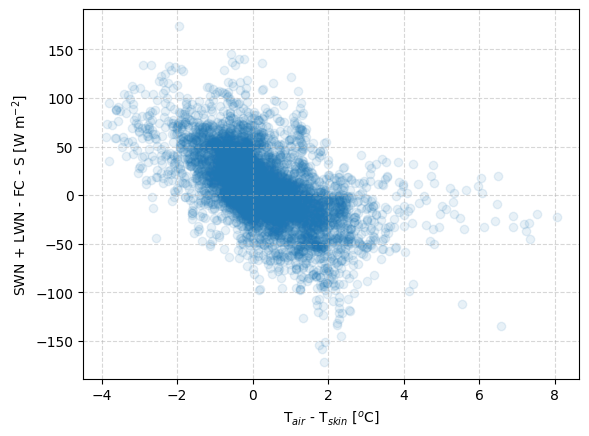

In [469]:
plt.scatter(interped_T2m_air[1:-1], resid_no_turb, alpha=.1)
plt.ylabel('SWN + LWN - FC - S [W m$^{-2}$]')
plt.xlabel('T$_{air}$ - T$_{skin}$ [$^o$C]')
plt.grid(alpha=.5, ls='--')
plt.show()

Relationship between residual and near surface stability is consistent with relationship you would expect from SH, but the values too large? But IDK wwhat I can do until Michael finishes the bulk fluxes


After talking with Matt and Michael, they believe that *if* SH averaged to ~0 over this time, *maybe* LH could explain the remaining energy

### Add accumulated fluxes to melt event figures? or highlight melt events in accumulation figures?
